# Capstone Project - The Battle of the Neighborhoods (Week 1)
### Applied Data Science Capstone by IBM/Coursera

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

### Problem Statement : Prospects of opening an Indian Restaurant in Toronto, Canada.

Toronto, the capital of the province of Ontario, is the most populous Canadian city. Its diversity is reflected in Toronto’s ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. One of the most immigrant-friendly cities in North America with more than half of the entire Indian Canadian population residing in Toronto, it is one of the best places to start an Indian restaurant.

In this project we will try to find an **optimal location for a restaurant** and make a decision whether it is a good idea to open an **Indian** restaurant in **Toronto**, Canada.

We already know that Toronto shelters a greater number of Indians than any other city in Canada and it may be a good idea to start the restaurant here, but we just need to make sure whether it is a profitable idea or not. If so, where we can place it so that it yields more profit to the owner.

Since there are lots of restaurants in Toronto we will try to detect **most profitable area since the success of any restaurant depends on the people, ambience and its location**. We are also particularly interested in **areas with Indians living in vicinity**.

We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Target Audience

**Who will be more interested in this project? What type of clients or a group of people would be benefitted?**  

* Business personnel who wants to invest or open an Indian restaurant in Toronto. This analysis will be a comprehensive guide to start or expand restaurants targeting the Indian crowd.  

* Freelancer who loves to have their own restaurant as a side business. This analysis will give an idea, how beneficial it is to open a restaurant and what are the pros and cons of this venture.  

* Indian crowd who wants to find neighborhoods with lots of option for Indian restaurants.  

* Business Analyst or Data Scientists, who wish to analyze the neighborhoods of Toronto using **Exploratory Data Analysis** and other **statistical & machine learning techniques** to obtain all the necessary data, perform some operations on it and, finally be able to tell a story out of it.



## Data (Sources and Cleaning)<a name="data"></a>

### Data Sources

* **“List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)** wiki page to get all the information about the neighborhoods present in Toronto. This page has the **postal code**, **borough** & the name of all the **neighborhoods** present in Toronto.

* In order to get all the **geographical coordinates** of the neighborhoods, we will be using **“https://cocl.us/Geospatial_data”** csv file.

* To get info about the distribution of population on the basis of their ethnicity, we will be using **“Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity)** wiki page.  
Using this page I’m going to identify the neighborhoods which are densely populated with Indians as it might be helpful in identifying the suitable neighborhood to open a new Indian restaurant.

* To get location and other information about various venues in Toronto, we will be using **Foursquare’s explore API**. Using the Foursquare’s explore API (which gives venues recommendations), we'll be fetching details about the venues up present in Toronto and collect their **names**, **categories** and **locations** (latitude and longitude).  

From **Foursquare API (https://developer.foursquare.com/docs)**, we get the following for each venue:
* **Name:** The name of the venue.
* **Category:** The category type as defined by the API.
* **Latitude:** The latitude value of the venue.
* **Longitude:** The longitude value of the venue.

### Data Cleaning

**a) Scraping Toronto Neighborhoods Table from Wikipedia** 

**Scraped the following Wikipedia page, “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods in it**

Assumptions made to attain the below DataFrame:

* Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
* Only the cells that have an assigned borough will be processed. <u>Borough that is not assigned are ignored.</u>
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be **combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.  

**<u>Wikipedia - Package</u>** is used to scrape the data from wiki.

In [4]:
!conda install -c conda-forge wikipedia --yes 

import pandas as pd
import numpy as np
import wikipedia as wp

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wikipedia


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi              pkgs/main::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [5]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html, header = 0)[0]
df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [6]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df = df.rename(columns={'Postcode': 'Postalcode'})

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
#So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']

df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [7]:
df = df.groupby(['Borough','Postal code'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postal code,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,Moore Park / Summerhill East


**b) Adding geographical coordinates to the neighborhoods**  

Next important step is adding the geographical coordinates to these neighborhoods. To do so, we will extract the data present in the Geospatial Data .csv file and combine it with the existing neighborhood dataframe by merging them both based on the postal code.

In [8]:
#Reading the latitude & longitude data from CSV file

import io
import requests

url = "https://cocl.us/Geospatial_data"
lat_long = requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Renaming the columns to match the existing dataframe

In [9]:
lat_long_df = lat_long_df.rename(columns={'Postal Code': 'Postal code'})
lat_long_df.head()

,Postal code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now, merging both the dataframes into one by connecting with their respective postal codes.

In [10]:
toronto_DF = pd.merge(df,lat_long_df, on='Postal code')
toronto_DF.head()

,Borough,Postal code,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_DF['Borough'].unique()),
        toronto_DF.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


**c) Scrap the distribution of population from Wikipedia**  

Another factor that can help us in deciding which neighborhood would be best option to open a restaurant is, the distribution of population based on the ethnic diversity for each neighborhood. As this will help us in identifying the neighborhoods which are densely populated with Indian residents since that neighborhood would be an ideal place to open an Indian restaurant.

Scraped the following Wikipedia page, **“Demographics of Toronto”** in order to obtain the data about the Toronto & the Neighborhoods in it.   

Compared to all the neighborhoods in Toronto below given neighborhoods only had considerable amount of Indian crowd. We are examining those neighborhoods' population to identify the densely populated neighborhoods with Indian population.

In [12]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [13]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[13]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [14]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[14]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[15]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[16]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,"Ethnic groups in the Toronto CMA (2016)Source: Focus on Geography Series, 2016 Census; Toronto, (CMA) - Ontario","Ethnic groups in the Toronto CMA (2016)Source: Focus on Geography Series, 2016 Census; Toronto, (CMA) - Ontario.1",Population,Ethnic Origin 1 in %
0,Ethnic group,White,2804630,47.8
1,Ethnic group,South Asian,973225,16.6
2,Ethnic group,Chinese,631045,10.8
3,Ethnic group,Black,442020,7.5
4,Ethnic group,Filipino,254480,4.3
5,Ethnic group,Latin American,132950,2.3
6,Ethnic group,West Asian,123755,2.1
7,Ethnic group,Arab,105610,1.8
8,Ethnic group,Southeast Asian,83540,1.4
9,Ethnic group,Korean,69670,1.2


**d) Get location data using Foursquare**

**Foursquare API** is very usefule online application used my many developers & other application like Uber etc. In this project, we have used it to retrieve information about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a dataframe.  

**Note:- Choosing 100 popular spots for each neighborhood within a radius of 1km.**

In [17]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

# All requested packages already installed.



In [18]:
#Use geopy library to get the latitude and longitude values of New York City.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [19]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



In [20]:
CLIENT_ID= 'TRXAE43HGOWVECVHYEZZ0UC0BAWZGYKN2ME1FBDESP2XQXBA'
CLIENT_SECRET= '25NRFBCNRR0ILBH0HKGF5KIKRX5M1MSV0NUGU1QRGFHJSO11'
VERSION = '20180604'
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [21]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Using the get_category_type function, we clean up the json and turn it into a pandas dataframe.  
Before we start, need to import certain libraries.

In [22]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


Now we can explore the nearby venues!

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park / Summerhill East
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Roselawn
Forest Hill North & West
The Annex / North Midtown / Yorkville
Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport
Stn A PO Boxes
First Canadian Place / Underground city
Christie
Queen's Park / Ontario Provincial Government
The Beaches
The Danforth West / Riverdale
India Bazaar / The Beaches West
Studio District
Business reply mail Processing CentrE
Parkview Hill / Woodbine Gardens

In [25]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
5,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
6,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
7,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
8,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place
9,Davisville North,43.712751,-79.390197,Circle K,43.712834,-79.391554,Convenience Store


In [26]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
Alderwood / Long Branch,8,8,8,8,8,8
Bathurst Manor / Wilson Heights / Downsview North,21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,24,24,24,24,24,24
...,...,...,...,...,...,...
Wexford / Maryvale,4,4,4,4,4,4
Willowdale,38,38,38,38,38,38
Woburn,3,3,3,3,3,3


In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


There are 269 unique categories in which Indian Restaurant is one of them. We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.

In [28]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bedford Park / Lawrence Manor East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Wexford / Maryvale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
89,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.0,0.0
90,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
91,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0


In [29]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop            186
Café                   100
Restaurant              71
Italian Restaurant      50
Park                    48
                      ... 
Boat or Ferry            1
Metro Station            1
Housing Development      1
Hospital                 1
College Cafeteria        1
Name: Venue Category, Length: 269, dtype: int64


## Methodology <a name="methodology"></a>

### Exploratory Data Analysis

**a) Folium Library and Leaflet Map**

Folium is a python library which we will be using to draw an interactive leaflet map using coordinate data.

In [30]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**b) Relationship between neighborhood and Indian Restaurant**  

First we will extract the Neighborhood and Indian Restaurant column from the above toronto dataframe for further analysis:

In [31]:
toronto_part = toronto_grouped[['Neighborhood', 'Indian Restaurant']]
toronto_part

,Neighborhood,Indian Restaurant
0,Agincourt,0.000000
1,Alderwood / Long Branch,0.000000
2,Bathurst Manor / Wilson Heights / Downsview North,0.000000
3,Bayview Village,0.000000
4,Bedford Park / Lawrence Manor East,0.041667
...,...,...
88,Wexford / Maryvale,0.000000
89,Willowdale,0.000000
90,Woburn,0.000000
91,Woodbine Heights,0.000000


In [32]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,Postal code,Neighborhood,Latitude,Longitude,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.027027
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160,0.000000
...,...,...,...,...,...,...
93,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,0.000000
94,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,0.000000
95,York,M6M,Del Ray / Mount Dennis / Keelsdale and Silvert...,43.691116,-79.476013,0.000000
96,York,M6N,Runnymede / The Junction North,43.673185,-79.487262,0.000000


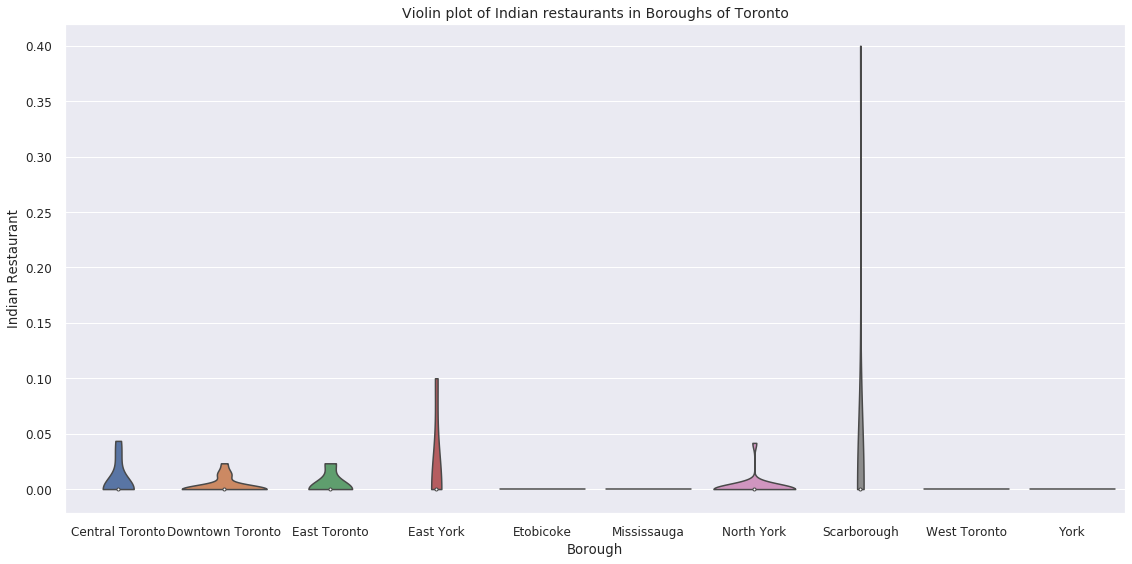

In [33]:
# Let's try Categorical plot 

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Indian Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plot of Indian restaurants in Boroughs of Toronto', fontsize=14)
plt.show()

This plot helps in identifying the boroughs with densely populated Indian restaurants.  

Lets visualize the neighborhood with Indian Restaurants.

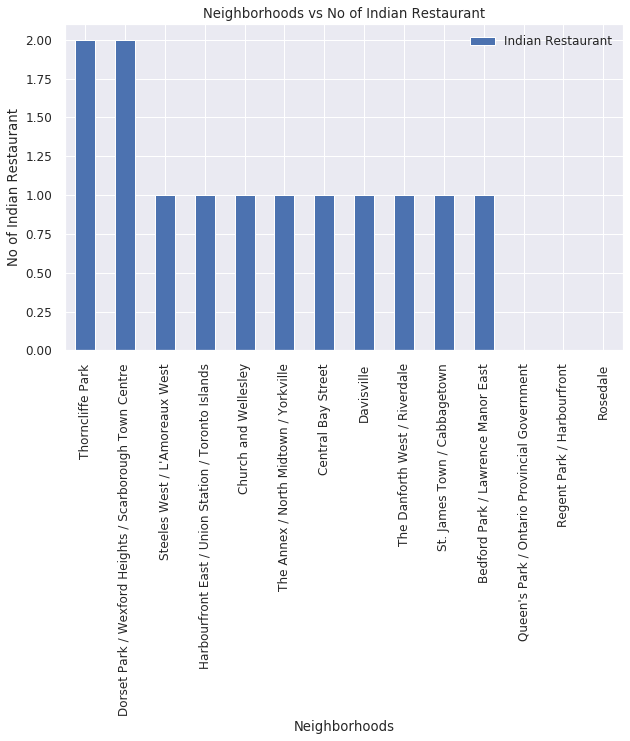

In [34]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by ='Indian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Indian Restaurant")
plt.title("Neighborhoods vs No of Indian Restaurant")
plt.show()

**c) Relationship between Neighborhoods and Indian population**

In [35]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
7,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
9,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above dataframe we can pickout the neighborhoods with highest Indian population percentage by using the below given method.

In [36]:
#Filtering the riding with Indian ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'East Indian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'East Indian')]
pop_indian_df = pd.DataFrame(temp).reset_index()
pop_indian_df.drop('index',axis=1,inplace=True)

pop_indian_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
9,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [37]:
#retaining only Indian ethnic percentage & the neighborhood name 
columns_list = pop_indian_df.columns.to_list()
pop_indian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_indian_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_indian_df.at[i, j] == 'East Indian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_indian_DF_with_percent = pop_indian_DF_with_percent.append({'Riding':pop_indian_df.at[i, 'Riding'], 'Population':pop_indian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_indian_df.at[i, j], 'Percentage': pop_indian_df.at[i, percent_col]},ignore_index=True)

pop_indian_DF_with_percent      

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,East Indian,12.2,110450.0,Scarborough Centre
1,East Indian,8.2,108295.0,Scarborough Southwest
2,East Indian,7.4,104225.0,Scarborough-Agincourt
3,East Indian,16.7,101445.0,Scarborough-Rouge Park
4,East Indian,18.0,101115.0,Scarborough-Guildwood
5,East Indian,11.8,97610.0,Scarborough North
6,East Indian,22.2,116960.0,Etobicoke North
7,East Indian,7.3,109060.0,Don Valley North
8,East Indian,9.2,107725.0,Humber River-Black Creek
9,East Indian,10.6,93170.0,Don Valley East


In [38]:
pop_indian_DF_with_percent['Indian Population'] = (pop_indian_DF_with_percent['Percentage'] * pop_indian_DF_with_percent['Population'])/100
pop_indian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_indian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_indian_DF_with_percent

,Riding,Indian Population
0,Scarborough Centre,13474.900
1,Scarborough Southwest,8880.190
2,Scarborough-Agincourt,7712.650
3,Scarborough-Rouge Park,16941.315
4,Scarborough-Guildwood,18200.700
5,Scarborough North,11517.980
6,Etobicoke North,25965.120
7,Don Valley North,7961.380
8,Humber River-Black Creek,9910.700
9,Don Valley East,9876.020


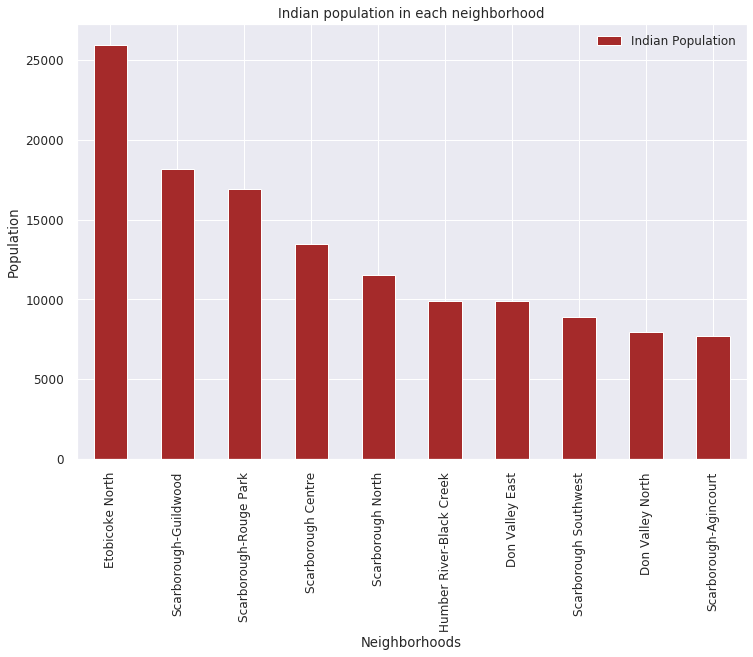

In [39]:
bar_graph = pop_indian_DF_with_percent.sort_values(by='Indian Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Indian Population',figsize=(12,8), color='brown')
plt.title("Indian population in each neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

This analysis & visualization of the relationship between neighborhoods & Indian population present in those neighborhoods helps us in identifying the our perfect locations for Indian restaurants.  

Once we identify those neighborhoods, it will help us in deciding where to place the new Indian restaurant. Indian restaurant placed in an densely populated Indian neighborhood is more likely to get more Indian customers than a restaurant placed in a neighborhood with less or no Indian population.  

Thus this analysis helps in determining the success of a new Indian restaurant in Toronto's neighborhoods.

**d) Relationship between Indian population and Indian restaurant**

First get the list of neighborhoods present in the riding using the wikipedia geography section for each riding.  
Altering the riding names to match the wikipedia page in order to retrieve the neighborhoods present in those ridings.

In [40]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_indian_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list

['Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Etobicoke North',
 'Don Valley North',
 'Humber River-Black Creek',
 'Don Valley East']

In [41]:
#Scraping wiki page to get the neighborhoods of ech Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wikipedia.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df

,Riding,Neighborhoods
0,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...
1,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
2,Scarborough-Agincourt,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
3,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
4,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."
5,Scarborough North (electoral district),"Agincourt (east of Midland Avenue), Milliken ..."
6,Etobicoke North,"The Elms, Humberwood, Kingsview Village, This..."
7,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."
8,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un..."
9,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."


In [42]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_indian_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop

,Indian Population,Neighborhoods
0,8880.190,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
1,7712.650,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
2,16941.315,"Morningside Heights, Rouge, Port Union, West ..."
3,18200.700,"Guildwood, West Hill (west of Morningside Ave..."
4,25965.120,"The Elms, Humberwood, Kingsview Village, This..."
5,7961.380,"Henry Farm, Bayview Village, Bayview Woods-St..."
6,9910.700,"Humber Summit, Humbermede, Humberlea, York Un..."
7,9876.020,"Flemingdon Park, Don Mills, Graydon Hall, Par..."


In [43]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,Indian Population,Neighborhood
0,8880.190,Birch Cliff
1,7712.650,Steeles
2,16941.315,Morningside Heights
3,18200.700,Guildwood
4,25965.120,The Elms
5,7961.380,Henry Farm
6,9910.700,Humber Summit
7,9876.020,Flemingdon Park
8,8880.190,Oakridge
9,7712.650,L'Amoreaux


In [46]:
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

,Indian Restaurant,Neighborhood
0,0.000000,Agincourt
1,0.000000,Alderwood / Long Branch
2,0.000000,Bathurst Manor / Wilson Heights / Downsview North
3,0.000000,Bayview Village
4,0.041667,Bedford Park / Lawrence Manor East
...,...,...
89,0.000000,Willowdale
90,0.000000,Woburn
91,0.000000,Woodbine Heights
92,0.000000,York Mills West


In [47]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.head()

,Indian Population,Neighborhood,Indian Restaurant


After performing the data cleaning & data analysis we can identify that their no big relationship established in terms of the Indian population & the popular Indian restaurants.

Thus, this marks the end of the data cleaning & analyses step in this project. Next we will be looking into the predictive modeling.  

**In the predictive modeling we are going to use Clustering techniques since this is analysis of unlabeled data. K-Means clustering is used to perform the analysis of the data at hand.**

### Predictive Modeling

**a) Clustering Neighborhoods of Toronto:**

First step in K-means clustering is to identify the best K value i.e the number of clusters in a given dataset.  

To do so we are going to use the elbow method on the Toronto dataset with Indian restaurant percentage **(i.e. toronto_merged dataframe)**

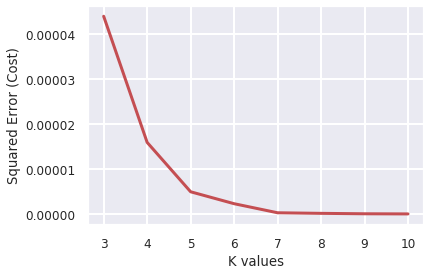

In [48]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [49]:
!conda install -c districtdatalabs yellowbrick --yes

from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - yellowbrick


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.4.5.1-py36h~ --> pkgs/main::certifi-2020.4.5.1-py36_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [61]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  self.estimator.fit(X)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 6 is the best value.  

**Clustering the Toronto Neighborhood Using K-Means with K = 6**

In [51]:
kclusters = 6

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 5, 0, 3, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [52]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_DF
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,3.0,0.027027
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160,0.0,0.000000


Let us see the clusters visually on the map with the help of Folium.

In [53]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

**b) Examing the Clusters:**

We have total of 6 clusters such as 0,1,2,3,4,5. Let us examine one after the other.  

Cluster 0 contains all the neighborhoods which has least number of Indian restaurants. It is shown in red color in the map

In [54]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.0
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160,0.0,0.0
5,Central Toronto,M4V,Summerhill West / Rathnelly / South Hill / For...,43.686412,-79.400049,0.0,0.0
...,...,...,...,...,...,...,...
92,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,0.0,0.0
93,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,0.0,0.0
94,York,M6M,Del Ray / Mount Dennis / Keelsdale and Silvert...,43.691116,-79.476013,0.0,0.0
95,York,M6N,Runnymede / The Junction North,43.673185,-79.487262,0.0,0.0


Cluster 1 contains the neighborhoods which is sparsely populated with Indian restaurants. It is shown in purple color in the map.

In [55]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
80,Scarborough,M1P,Dorset Park / Wexford Heights / Scarborough To...,43.75741,-79.273304,1.0,0.4


Cluster 2 has no rows meaning no data points or neighborhood was near to this centroid.

In [56]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
85,Scarborough,M1W,Steeles West / L'Amoreaux West,43.799525,-79.318389,2.0,0.0625


Cluster 3 contains all the neighborhoods which is medium populated with Indian restaurants. It is shown in blue color in the map.

In [57]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,3.0,0.027027
10,Downtown Toronto,M4X,St. James Town / Cabbagetown,43.667967,-79.367675,3.0,0.023256
11,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,3.0,0.013158
15,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,3.0,0.015625
28,East Toronto,M4K,The Danforth West / Riverdale,43.679557,-79.352188,3.0,0.023256


Cluster 4 has no rows meaning no data points or neighborhood was near to this centroid.

In [58]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
35,East York,M4H,Thorncliffe Park,43.705369,-79.349372,4.0,0.1


Cluster 5 contains all the neighborhoods which is densely populated with Indian restaurants. It is shown in Orange color on the map.

In [59]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Borough,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
8,Central Toronto,M5R,The Annex / North Midtown / Yorkville,43.672710,-79.405678,5.0,0.043478
64,North York,M5M,Bedford Park / Lawrence Manor East,43.733283,-79.419750,5.0,0.041667


##  Results and Discussion <a name="results"></a>

### Results

We have reached the end of the analysis, in the result section we can document all the findinds from above clustering & visualization of the datas. In this project, as the business problem started with identifying a good neighborhood to open a new Indian restaurant, we looked into all the neighborhoods in Toronto, analysed the Indian population in each neighborhood & spread of Indian restaurants in those neighborhoods to come to conclusion about which neighborhood would be a better spot for opening a new Indian restaurant. I have used data from web resources like Wikipedia, geospatial coordinates of Toronto neighborhoods, and Foursquare API, to set up a very realistic data-analysis scenario. We have found out that —

* In those 11 boroughs we identified that only Central Toronto, Downtown Tronto, East Toronto, East York, North York & Scarborough boroughs have high amount of Indian restaurants with the help of Violin plots between Number of Indian restaurants in Borough of Toronto.

* In all the ridings, Scarborough-Guildwood, Scarborough-Rouge Park, Scarborough Centre, Scarborough North, Humber River-Black Creek, Don Valley East, Scarborough Southwest, Don Valley North & Scarborough-Agincourt are the densely populated with Indian crowd ridings.

* With the help of clusters examing & violin plots looks like Downtown Toronto, Central Toronto, East York are already densely populated with Indian restaurants. So it is better idea to leave those boroughs out and consider only Scarborough, East Toronto & North York for the new restaurant's location.

* After careful consideration it is a good idea to open a new Indian restaurant in Scarborough borough since it has high number of Indian population which gives a higher number of customers possibility and lower competition since very less Indian restaurants in the neighborhoods.

### Discussion

According to this analysis, Scarborough borough will provide least competition for the new upcoming Indian restaurant as there are very little Indian restaurants spread or no Indian restaurants in neighborhoods. Also looking at the population distribution, it looks like it is densely populated with Indian crowd which gives the new restaurant high possibility of customers.  

So, definitely this region could potentially be a perfect place for starting a quality Indian restaurant.  

Some of the drawbacks of this analysis are — 

* The clustering is completely based only on data obtained from Foursquare API.
* The Indian population distribution in each neighborhood is also based on the 2016 census which is not up-to date. Thus population distribution would have definitely changed by 2020 given 3 years gap in the data. 
* Since population distribution of Indian crowd in each neighborhood & number of Indian restaurants are the major features in this analysis, it is not fully up-to date data, this analysis is definitely not far from being conclusive & it has lot of areas where it can be improved.   

However, it certainly provides us with some good insights, preliminary information on possibilities & a head start into this business problem by setting the step stones properly. Furthermore, this may also potentially vary depending on the type of clustering techniques that we use to examine the data.

## Conclusion <a name="conclusion"></a>

Finally to conclude this project, we got a chance to solve a business problem like real data scientists would do. We have used many python libraries to fetch the data , to manipulate the contents & to analyze and visualize those datasets.   

We have made use of Foursquare API to explore the venues in neighborhoods of Toronto, then got a good amount of data from Wikipedia which we scraped with the help of Wikipedia Python Library and Visualized it using various plots present in seaborn & matplotlib.  

We also applied **machine learning techniques** to predict the output given by the data as well as used Folium to visualize it on a map.  

Also, some of the drawbacks or areas of improvements shows us that this analysis can further be improved with the help of more data and different machine learning techniques.  

Similarly we can use this project to analysis any scenario such as opening a different cuisine or success of opening a new gym etc. Hopefully, this project helps acts as initial guidance to take more complex real-life challenges using data-science.